In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import copy
import random
from tqdm import tqdm
from collections import deque

In [2]:
env = gym.make('CartPole-v0')

In [3]:
inp = Input((env.observation_space.shape))
x = Dense(32, activation='elu')(inp)
x = Dense(64, activation='elu')(x)
x = Dense(128, activation='elu')(x)
x = Dense(128, activation='elu')(x)
v = Dense(1)(x)
pi = Dense(2, activation='softmax')(x) # 2 == env.action_space.n
m = Model(inp, [v, pi])
m.compile(optimizer=Adam(lr=1e-3), loss=['mse', 'categorical_crossentropy'])

In [4]:
buffer = deque(maxlen=500)

In [5]:
def choose_action(env, evaluate=False):
    values = []
    for a in range(env.action_space.n):
        e = copy.deepcopy(env)
        o, r, d, _ = e.step(a)
        v, pi = m(tf.convert_to_tensor([e.state], dtype=tf.float32))
        v = v.numpy()[0][0]
        values.append(v)
    if evaluate:
        return np.argmax(values)
    else:
        for i in range(len(values)):
            if values[i] < 0:
                values[i] = 0
        s = sum(values)
        if s == 0:
            return np.random.choice(values)
        for i in range(len(values)):
            values[i] /= s
        return np.random.choice(range(env.action_space.n), p=values)

In [6]:
gamma = 0.997
batch_size = 64
evaluate = False
scores = []
avg_scores = []
epochs = 1_000

for episode in tqdm(range(epochs)):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        '''
        v, pi = m(tf.convert_to_tensor([env.state], dtype=tf.float32))
        v = v.numpy()[0][0]
        pi = pi.numpy()[0]
        
        if not evaluate:
            noise = np.random.dirichlet([.03]*env.action_space.n)
            for n in range(len(noise)):
                pi[n] = .75*pi[n] + .25*noise[n]
            a = np.random.choice([i for i in range(env.action_space.n)], p=pi)
        else:
            a = np.argmax(pi)
            
        a_pi = np.zeros((2)); a_pi[a] = 1
        '''
        
        a = choose_action(env, evaluate=evaluate)
        a_pi = np.zeros((2)); a_pi[a] = 1

        obs_, r, done, _ = env.step(a)
        score += r
        buffer.append([obs, None, a_pi])
        obs = obs_

    #print(f'score: {score}')
    scores.append(score)

    if len(scores) >= 100:
        avg_scores.append(np.mean(scores[-100:]))
    else:
        avg_scores.append(np.mean(scores))    
    
    cnt = score
    for i in range(len(buffer)):
        if buffer[i][1] == None:
            buffer[i][1] = cnt / 200
            cnt -= 1
    assert(cnt == 0)
    
    if len(buffer) >= batch_size:
        batch = []
        indexes = np.random.choice(len(buffer), batch_size, replace=False)
        for i in range(batch_size):
            batch.append(buffer[indexes[i]])
        states = tf.convert_to_tensor([transition[0] for transition in batch], dtype=tf.float32)
        values = tf.convert_to_tensor([transition[1] for transition in batch], dtype=tf.float32)
        policies = tf.convert_to_tensor([transition[2] for transition in batch], dtype=tf.float32)
        for _ in range(2):
            m.train_on_batch(states, [values, policies])

100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


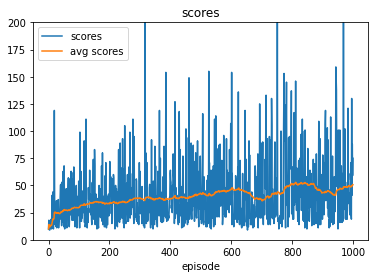

In [7]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.plot(avg_scores)
plt.xlabel('episode')
plt.legend(['scores', 'avg scores'])
plt.title('scores')
plt.ylim(0, 200)
plt.show()

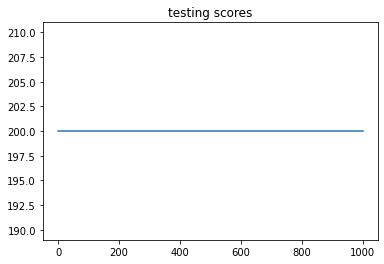

In [19]:
tests = 1_000
scores = []
for episode in range(tests):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        v, pi = m(tf.convert_to_tensor([env.state], dtype=tf.float32))
        v = v.numpy()[0][0]
        pi = pi.numpy()[0]        
        a = np.argmax(pi)            
        obs_, r, done, _ = env.step(a)
        score += r
        obs = obs_
    scores.append(score)
plt.plot(scores)
plt.title('testing scores')
plt.show()